# Business Problem

Apollo Hospitals was established in 1983, renowned as the architect of modern healthcare in India. As the nation's first corporate hospital, Apollo Hospitals is acclaimed for pioneering the private healthcare revolution in the country.

As a data scientist working at Apollo 24/7, the ultimate goal is to tease out meaningful and actionable insights from Patient-level collected data.

You can help Apollo hospitals to be more efficient, to influence diagnostic and treatment processes, to map the spread of a pandemic.

One of the best examples of data scientists making a meaningful difference at a global level is in the response to the COVID-19 pandemic, where they have improved information collection, provided ongoing and accurate estimates of infection spread and health system demand, and assessed the effectiveness of government policies.

How can you help here?

**The company wants to know:**<br>
• Which variables are significant in predicting the reason for hospitalization for different regions<br>
• How well some variables like viral load, smoking, severity Level describe the hospitalization charges<br>

**Column Profiling:**<br>
**Age:** This is an integer indicating the age of the primary beneficiary (excluding those above 64 years, since they are generally covered by the government). <br>
**Sex:** This is the policy holder's gender, either male or female<br>
**Viral Load:** Viral load refers to the amount of virus in an infected person's blood<br>
**Severity Level:** This is an integer indicating how severe the patient is<br>
**Smoker:** This is yes or no depending on whether the insured regularly smokes tobacco.<br>
**Region:** This is the beneficiary's place of residence in Delhi, divided into four geographic regions - northeast, southeast, southwest, or northwest<br>
**Hospitalization charges:** Individual medical costs billed to health insurance<br>

# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("seaborn-whitegrid")
import datetime as dt
import statsmodels.api as sm
from scipy.stats import shapiro, f_oneway, levene, ttest_ind, chi2_contingency

import warnings
warnings.filterwarnings('ignore')

# Import & Clean Data

### Code

In [2]:
class print_format:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'
    
    @staticmethod
    def print_line(num_lines = 90):
        print(print_format.BOLD + print_format.GREEN + "-"*num_lines + print_format.END)
    

class BasicDataChecks:
    pd.set_option('expand_frame_repr', False)
    
    def __init__(self, data_loc):
        self.data = pd.read_csv(data_loc, index_col=0)
        self.rename_cols()
    
    def rename_cols(self):
        cols = self.data.columns.str.replace(" ", "_")
        self.data.columns = cols
    
    def check_null(self):
        return self.data.isnull().sum()
    
    def check_duplicates(self):
        if self.data.duplicated().sum() > 0:
            return self.data[self.data.duplicated(keep=False)]
        return self.data.duplicated().sum()
    
    @property
    def check(self):
        print_format.print_line()
        print(print_format.BOLD + "Data head: " + print_format.END)
        print(self.data.head())
        print_format.print_line()
        print(print_format.BOLD + "Data tail:  " + print_format.END)
        print(self.data.tail())
        print_format.print_line()
        print(print_format.BOLD + "Null Values: " + print_format.END)
        print(self.check_null())
        print_format.print_line()
        print(print_format.BOLD + "Duplicate Values: " + print_format.END)
        print(self.check_duplicates())
        print_format.print_line()
        print(print_format.BOLD + "Data Info: " + print_format.END)
        print(self.data.info())
        print_format.print_line()
        print(print_format.BOLD + "Data Description: " + print_format.END)
        print(self.data.describe())
        print_format.print_line()

## Data Checks - Null, Duplicate, etc.

In [3]:
basic_data_checks = BasicDataChecks("scaler_apollo_hospitals.csv")
basic_data_checks.check
data = basic_data_checks.data

------------------------------------------------------------------------------------------
Data head: 
   age     sex smoker     region  viral_load  severity_level  hospitalization_charges
0   19  female    yes  southwest        9.30               0                    42212
1   18    male     no  southeast       11.26               1                     4314
2   28    male     no  southeast       11.00               3                    11124
3   33    male     no  northwest        7.57               0                    54961
4   32    male     no  northwest        9.63               0                     9667
------------------------------------------------------------------------------------------
Data tail:  
      age     sex smoker     region  viral_load  severity_level  hospitalization_charges
1333   50    male     no  northwest       10.32               3                    26501
1334   18  female     no  northeast       10.64               0                     5515
1335   18 

<div class="alert alert-block alert-success"><b><i>Observations</i></b></div>
<ul>
<li>No null values in the data set</li>
<li>One duplicate might be present - no way of confirming this. So, not deleting the data point.</li>
    <li>Data is available for <b>1338</b> patients.</li>
<li>Ages from 18 to 64 are covered. An average patient is 39 years old. And the age fluctates between 39 $\pm$ 14.</li>
<li>On average, the viral load fluctaures from 8 to 12.</li>
<li>Most of the patients have low sevierity levels.</li>
<li>Hospitalisation charges have a very high swing ranging from as low as ₹2805 to as high as ₹159426.</li>
</ul>

<div class="alert alert-block alert-info"><b><i>Additional Views</i></b></div>
<ul>
<li>Based on the region, we should check which variables are more dominant in predicting for hospitalisation.</li>
<li>At the same time, we should analyse, how the charges change based on the age, sex, viral load, severity level, and smoker.</li>
<li>We should also check if there is a dependence of the severity level with age, sex and viral load.</li>
</ul>

### Code

In [4]:
class ExploratoryDataAnalysis:
    def __init__(self, data: pd.DataFrame, cat_vars: list):
        self.data = data
        self.cat_vars = cat_vars
       
    def frequency_plot(self):
        fig, ax = plt.subplots(nrows=int(len(self.cat_vars) / 3), ncols=3, sharey=True, figsize=(15, 5))
        for num, col in enumerate(self.cat_vars):
            plot = sns.countplot(data = self.data, x = col, ax = ax[num])
            ax[num].set_title(f"{col}s", fontsize=14)
            for patch in plot.patches:
                ax[num].annotate(patch.get_height(), (patch.get_x()+0.35, patch.get_height()+5))
        plt.show()
    
    def violin_plot(self):
        fig, ax = plt.subplots(nrows=int((len(self.data.columns) - len(self.cat_vars)) / 4), ncols=4, figsize=(20, 5))
        cols = self.data.columns[~self.data.columns.isin(pd.Index(self.cat_vars))].tolist()
        for num, col in enumerate(cols):
            sns.violinplot(data = self.data[col], ax=ax[num], color = (np.random.random(), np.random.random(), np.random.random()), inner = 'box', grid=True)
            ax[num].set_title(f"{col}", fontsize=14)
            ax[num].get_children()[1].set_color('k')
            ax[num].get_children()[1].set_lw(5)
            
            ax[num].get_children()[2].set_color('w')
            ax[num].get_children()[3].set_color('w')
            ax[num].set_xticks([])
            ax[num].axhline(self.data[col].mean(), color = 'pink', lw = 4)
            ax[num].legend({f'Mean {round(self.data[col].mean(), 2)}':self.data[col].mean()})
        plt.show()
    
    @property
    def univariate_analysis(self):
        print_format.print_line(175)
        print(print_format.PURPLE + print_format.BOLD + "Count of Categorical Variables: \n" + print_format.END)
        self.frequency_plot()
        print_format.print_line(175)
        print(print_format.PURPLE + print_format.BOLD + "Distribution of Continuous Variables: \n" + print_format.END)
        self.violin_plot()
        print_format.print_line(175)
        
    def correlation(self):
        fig, ax = plt.subplots(1, 1, figsize=(10, 5))
        fig.suptitle("Variable Correlation", fontsize=20)
        cols = self.data.select_dtypes([np.number]).columns
        corr = self.data[cols].corr().abs().unstack()
        sns.heatmap(data = self.data[cols].corr(), annot=True, lw=0.2, cmap='Greens')
        
    @staticmethod
    def plot_heatmap(cross_table, fmt='g'):
        fig, ax = plt.subplots(figsize=(8, 5))
        heatmap = sns.heatmap(cross_table,
                    annot=True,
                    fmt=fmt,
                    cmap='rocket_r',
                    linewidths=.5,
                    ax=ax)
        heatmap.set_xticklabels(heatmap.get_xticklabels(), 
                                rotation=45, 
                                horizontalalignment='right', fontsize=14)
        heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=14)
        
        plt.show();
        return ax
    
    def contigency_table(self, index, columns, normalize=False, margins=False, margins_name=None, values=None, aggfunc=None, plot=False, fmt='g'):
        cross_data = self.data
        if values:
            values = cross_data[values]
            
        cross_table = pd.crosstab(index = [cross_data[idx] for idx in index], columns = [cross_data[col] for col in columns], 
                          normalize=normalize, 
                          margins=margins, margins_name=margins_name, 
                          values=values, aggfunc=aggfunc)
        
        if plot:
            ExploratoryDataAnalysis.plot_heatmap(cross_table, fmt=fmt)
        else:
            return cross_table
        
    def pair_plot(self, hue):
        g = sns.pairplot(data=self.data, hue=hue, kind='scatter', palette='Set1')
        g.map_lower(sns.kdeplot, levels=4, color=".1")
    
    @property
    def bivariate_analysis(self):
        print_format.print_line(100)
        print(print_format.PURPLE + print_format.BOLD + "Correlation between Continuous Variables: \n" + print_format.END)
        eda.correlation()
        plt.show()

        print_format.print_line(100)
        print(print_format.PURPLE + print_format.BOLD + "Pairplot with Smoking: \n" + print_format.END)
        eda.pair_plot(hue='smoker')
        plt.show()

        print_format.print_line(100)
        print(print_format.PURPLE + print_format.BOLD + "Region-wise Severity Level: \n" + print_format.END)
        eda.contigency_table(index=["region"], columns = ["severity_level"], normalize='index', plot=True, fmt='.2%')
        plt.show()

        print_format.print_line(65)
        print(print_format.PURPLE + print_format.BOLD + "Region-wise Sex Distribution: \n" + print_format.END)
        eda.contigency_table(index=["region"], columns = ["sex"], normalize='index', plot=True, fmt='.2%')
        plt.show()

        print_format.print_line(65)
        print(print_format.PURPLE + print_format.BOLD + "Sex and Smoking: \n" + print_format.END)
        eda.contigency_table(index=["smoker"], columns = ["sex"], normalize='index', plot=True, fmt='.2')
        plt.show()

        print_format.print_line(65)
        print(print_format.PURPLE + print_format.BOLD + "Sex-wise Severity Level: \n" + print_format.END)
        eda.contigency_table(index=["sex"], columns = ["severity_level"], normalize='index', plot=True, fmt='.2%')
        plt.show()

        print_format.print_line(65)
        print(print_format.PURPLE + print_format.BOLD + "Smoker and Severity Level: \n" + print_format.END)
        eda.contigency_table(index=["smoker"], columns = ["severity_level"], normalize='index', plot=True, fmt='.2%')
        plt.show()
        
        print_format.print_line(150)
        print(print_format.PURPLE + print_format.BOLD + "Sex | Smoker | Severity | Charges: \n" + print_format.END)
        sns.catplot(data = self.data, x='sex', y = 'hospitalization_charges', hue='severity_level', col='smoker', kind='bar', sharex=False, height=6, aspect=1.25, palette='hot')
        plt.show()
        print_format.print_line(150)
        print(print_format.PURPLE + print_format.BOLD + "Sex | Smoker | Severity | Age: \n" + print_format.END)
        sns.catplot(data = self.data, x='sex', y = 'age', hue='severity_level', col='smoker', kind='bar', sharex=False, height=6, aspect=1.25, palette='hot')
        plt.show()

## Data Exploration

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Count of Categorical Variables: 



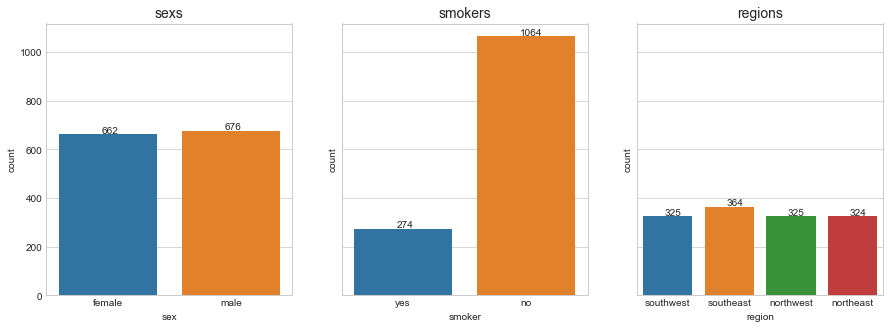

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Distribution of Continuous Variables: 



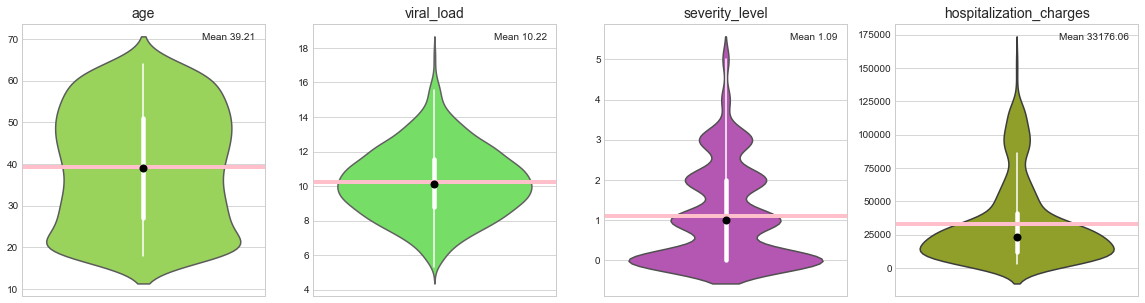

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [5]:
eda = ExploratoryDataAnalysis(data, ["sex", "smoker", "region"])
eda.univariate_analysis

<div class="alert alert-block alert-success"><b><i>Observations</i></b></div>
<ul>
<li>Sexes are almost balanced in number.</li>
<li>We have much more non-smokers.</li>
<li>Region-wise count is almost the same as well.</li>
<li>Ages from 18 to 64 are covered. An average patient is 39 years old. And the age fluctates between 39 $\pm$ 14.</li>
<li>Age while not normally distributed indicates that most number of cases were among the youngsters. The average age however for people getting infected is 39 years. Most people infected are within the age group of 25 to 50 years.
<li>Viral load seems to follow a normal distribution. The mean load is 10.22. Median is around the same. However, it suffers from outliers as well.
<li> Severity level is not continuous. Most people do not suffer from severe covid either. On average the severity level is a little above one. As expected, the number patients decline as and when the severity level increases.
<li>On average people are paying ₹33000 for treatment. However, the data suffers severe right tail outliers. People have spent upto ₹150000 too. Most people however spend around ₹25000 as expenditure.
</ul>

----------------------------------------------------------------------------------------------------
Correlation between Continuous Variables: 



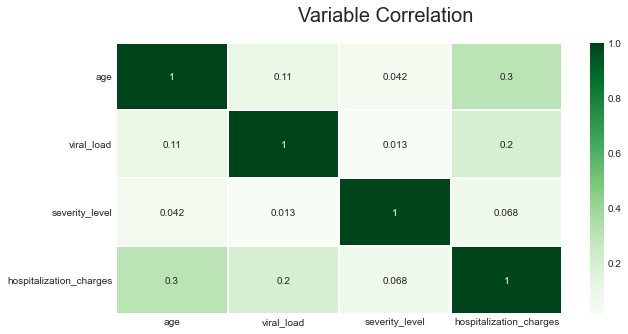

----------------------------------------------------------------------------------------------------
Pairplot with Smoking: 



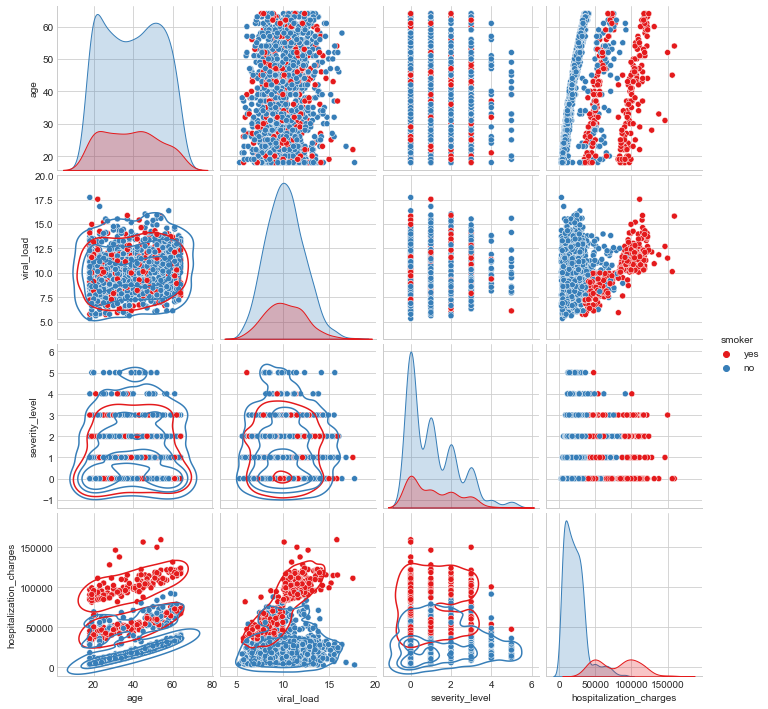

----------------------------------------------------------------------------------------------------
Region-wise Severity Level: 



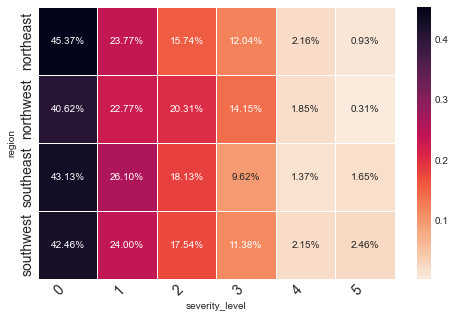

-----------------------------------------------------------------
Region-wise Sex Distribution: 



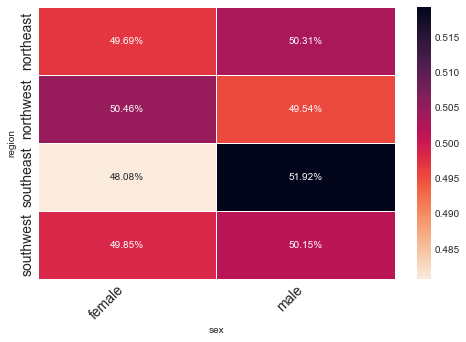

-----------------------------------------------------------------
Sex and Smoking: 



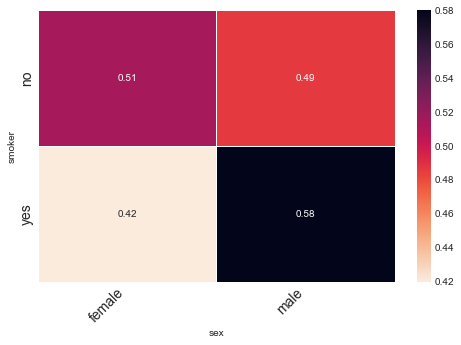

-----------------------------------------------------------------
Sex-wise Severity Level: 



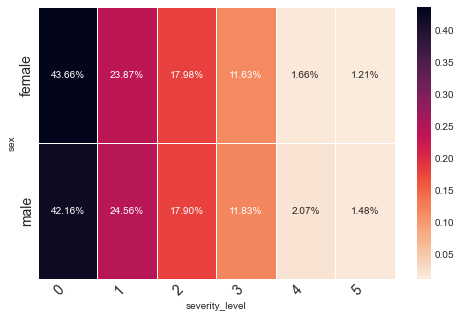

-----------------------------------------------------------------
Smoker and Severity Level: 



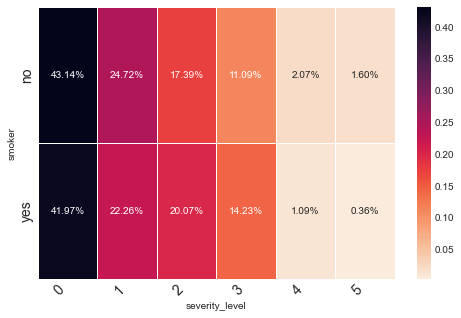

------------------------------------------------------------------------------------------------------------------------------------------------------
Sex | Smoker | Severity | Charges: 



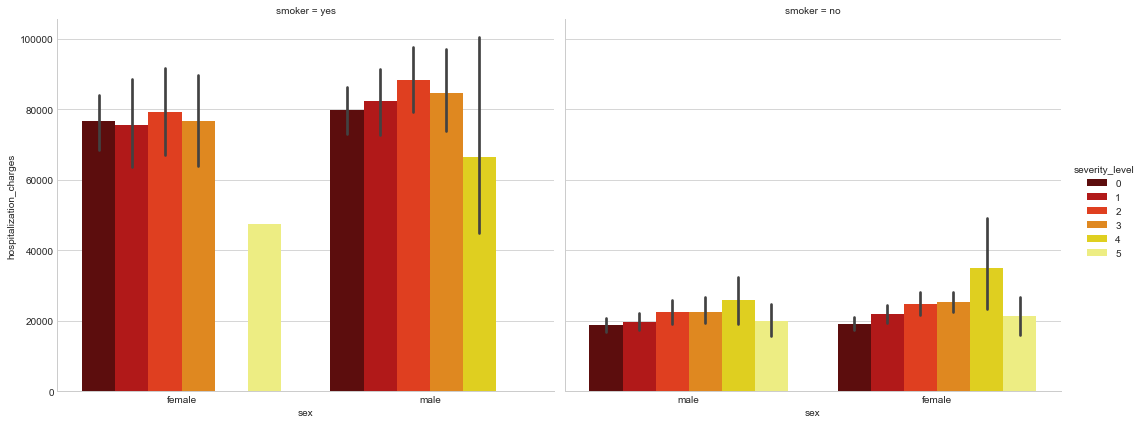

------------------------------------------------------------------------------------------------------------------------------------------------------
Sex | Smoker | Severity | Age: 



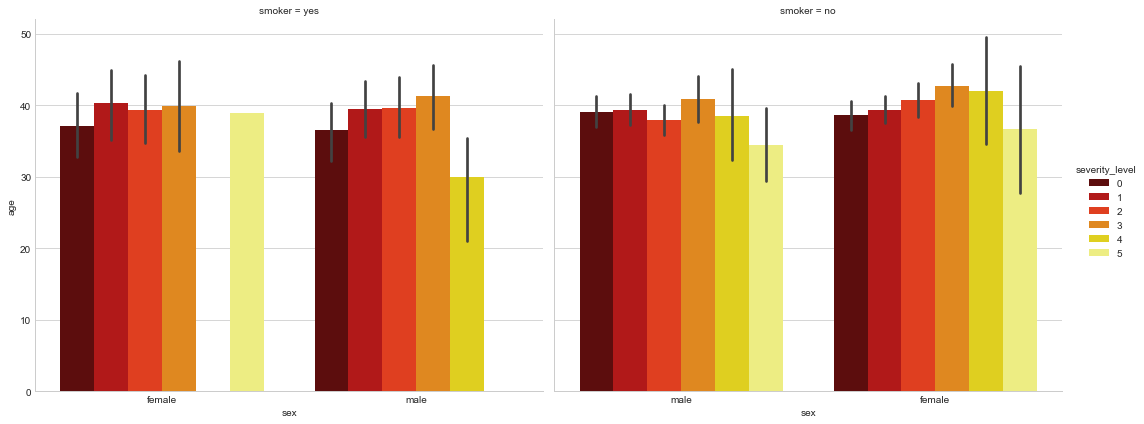

In [6]:
eda.bivariate_analysis

## Business Insights
<ul>
    <li>Correlation between the variables is not as strong. Although hospitalization charges are affected by age and viral load to an extent. Age and viral load also show small level of dependence.</li>
    <li>
        <b>Pairplot:</b>
        <ul>
            <li> Age and hospital charges, while independently show small relationship, taken together with smoking, the charges become much more clear. Given the same age, smokers are charged more.
            <li> Viral load is not related by age or severity level. However, smokers are again charged higher for the same viral load. It doesn't seem to have a relationship with severity level either.
            <br>Basically, given two people, if one smokes, he will be charged higher.
        </ul>
    <li>Southeast and southwest see slighty more Level 1 severity as compared to the other two regions. At the same time, northwest has higher Level 2 and Level 3 severity. Southwest sees a higher chunk of
        Level 4 and 5, while northeast and southwest see almost the same level of Level 4 severity.
    <li>Gender distribution is fairly equitable in all regions.
    <li>Males smoke more than females.
    <li>Severity levels for males and females are in almost the same proportion.
    <li>Smokers tend to have higher Level 3 severity, while having a suprisingly lower severity compared to other non-smokers in other levels.
</ul>

## Hypothesis Testing

### Code

In [7]:
class HypothesisTesting:
    def __init__(self, data):
        self.data = data
    
    def _plot_qq_hist(self, variable, alpha):
        fig, ax = plt.subplots(1, 2, figsize=(10, 5))
        fig.suptitle(f"Normality Check for {variable.name}")
        sm.qqplot(np.array(variable), line='s', ax = ax[0])
        ax[0].set_title("Q-Q Plot")
        sns.histplot(variable, kde=True, ax = ax[1])
        ax[1].set_title("Distribution Plot")
        plt.show()
    
    def _shapiro_wilk(self, variable, alpha):
        pval = shapiro(variable).pvalue
        if pval > alpha:
            s1 = f"Shapiro-Wilk p-val: {round(pval, 2)} | alpha: {alpha}\nWe do not have sufficient evidence to say that {variable.name} doesn't come \nfrom a normal distribution."
            print_format.print_line(85)
            print(print_format.GREEN + print_format.BOLD + s1 + print_format.END)
            print_format.print_line(85)
        else:
            s2 = f"Shapiro-Wilk p-val: {round(pval, 2)} | alpha: {alpha}\nWe have sufficient evidence to say that {variable.name} doesn't come \nfrom a normal distribution."
            print_format.print_line(85)
            print(print_format.RED + print_format.BOLD + s2 + print_format.END)
            print_format.print_line(85)
        
    def normality_check(self, variable, alpha = 0.05, check_log_normal = True):
        print_format.print_line(85)
        print(print_format.PURPLE + print_format.BOLD + f"{variable.name}\n")
        self._plot_qq_hist(variable, alpha)
        self._shapiro_wilk(variable, alpha)
        
        if check_log_normal:
            print(print_format.CYAN + print_format.BOLD + "Checking for Normality after Log-transformation:\n" + print_format.END)
            variable = np.log(variable)
            self._plot_qq_hist(variable, alpha)
            self._shapiro_wilk(variable, alpha)
        
    def variance_check(self, *args, center='median', proportiontocut=0.05):
        print_format.print_line(85)
        print(print_format.BLUE + print_format.BOLD + "Levene's Test For Variance" + print_format.END)
        var = [arg.name for arg in args]
        print(print_format.CYAN + print_format.BOLD + f"Variables: {var}" + print_format.END)
        
        pval = levene(*args, center='median', proportiontocut=proportiontocut).pvalue
        print(print_format.PURPLE+ print_format.BOLD + f"Proportion Cut: {proportiontocut} | pvalue: {round(pval, 2)}" + print_format.END)
        
        if pval > proportiontocut:
            print_format.print_line(85)
            s1 = "We do not have sufficient evidence to say that the variables don't have equal variance."
            print(print_format.GREEN + print_format.BOLD + s1 + print_format.END)
            print_format.print_line(85)
        else:
            print_format.print_line(85)
            s1 = "We have sufficient evidence to say that the variables don't have equal variance."
            print(print_format.RED + print_format.BOLD + s1 + print_format.END)
            print_format.print_line(85)
            
    def ind_ttest(self, a, b, axis=0, equal_var=True, nan_policy='propagate', permutations=None, random_state=None, alternative='two-sided', trim=0, alpha = 0.05, ret = False):
        stat, pval = ttest_ind(a, b, axis=0, equal_var=True, nan_policy='propagate', permutations=None, random_state=None, alternative='two-sided', trim=0)
        
        print_format.print_line(65)
        print(print_format.BOLD + print_format.CYAN + f"t-test | {a.name, b.name}" + print_format.END)
        print(print_format.RED + f"alpha: {alpha}" + print_format.END + " | " + print_format.BLUE + f"pval: {round(pval, 2)}" + print_format.END)
        
        if pval > alpha:
            print(print_format.BOLD + print_format.RED + "We do not have sufficient evidence to reject the null hypothesis." + print_format.END)
        else:
            print(print_format.BOLD + print_format.GREEN + "We have sufficient evidence to reject the null hypothesis." + print_format.END)
            
        print_format.print_line(65)
        if ret:
            return stat, pval
    
    def one_way_anova(self, *args, axis=0, alpha = 0.05, ret = False):
        stat, pval = f_oneway(*args, axis=0)
        
        print_format.print_line(65)
        print(print_format.BOLD + print_format.CYAN + f"one-way ANOVA" + print_format.END)
        print(print_format.RED + f"alpha: {alpha}" + print_format.END + " | " + print_format.BLUE + f"pval: {round(pval, 2)}" + print_format.END)
        
        if pval > alpha:
            print(print_format.BOLD + print_format.RED + "We do not have sufficient evidence to reject the null hypothesis." + print_format.END)
        else:
            print(print_format.BOLD + print_format.GREEN + "We have sufficient evidence to reject the null hypothesis." + print_format.END)
            
        print_format.print_line(65)
        if ret:
            return stat, pval
    
    def chi2(self, observed, correction=True, lambda_=None, alpha = 0.05, ret = False):
        stat, pval, dof, expected = chi2_contingency(observed, correction=True, lambda_=None)
        
        print_format.print_line(65)
        print(print_format.BOLD + print_format.CYAN + f"Chi-squared test" + print_format.END)
        print(print_format.RED + f"alpha: {alpha}" + print_format.END + " | " + print_format.BLUE + f"pval: {round(pval, 3)}" + print_format.END)
        
        if pval > alpha:
            print(print_format.BOLD + print_format.RED + "We do not have sufficient evidence to reject the null hypothesis." + print_format.END)
        else:
            print(print_format.BOLD + print_format.GREEN + "We have sufficient evidence to reject the null hypothesis." + print_format.END)
            
        print_format.print_line(65)
        if ret:
            return stat, pval

In [8]:
hypo_test = HypothesisTesting(data)
hypo_test_data = hypo_test.data

---
### Hospitalisation Charges of People Who Smoke Are Greater Than Those Who Don't
**Hypothesis:**<br><br>
$ H_{0}: x_{smoke} <= x_{no\space smoke} $ <br>
$ H_{1}: x_{smoke} > x_{no\space smoke} $


$\alpha = 0.05$

where, $x$ is the hospitalisation charge of a person.

-------------------------------------------------------------------------------------
hospitalization_charges_smoker



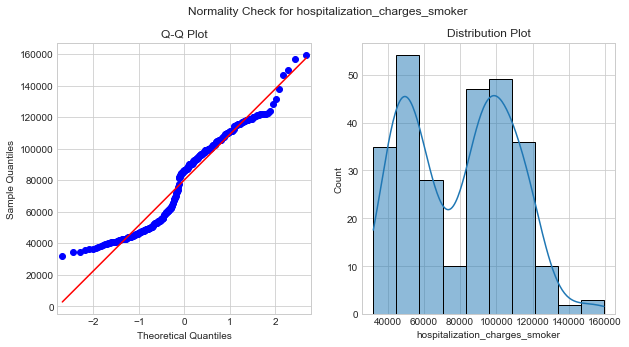

-------------------------------------------------------------------------------------
Shapiro-Wilk p-val: 0.0 | alpha: 0.05
We have sufficient evidence to say that hospitalization_charges_smoker doesn't come 
from a normal distribution.
-------------------------------------------------------------------------------------
Checking for Normality after Log-transformation:



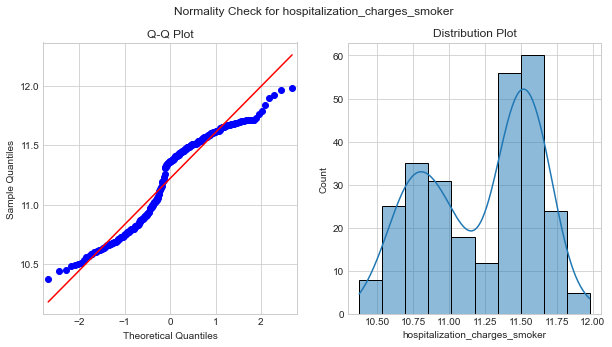

-------------------------------------------------------------------------------------
Shapiro-Wilk p-val: 0.0 | alpha: 0.05
We have sufficient evidence to say that hospitalization_charges_smoker doesn't come 
from a normal distribution.
-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
hospitalization_charges_non_smoker



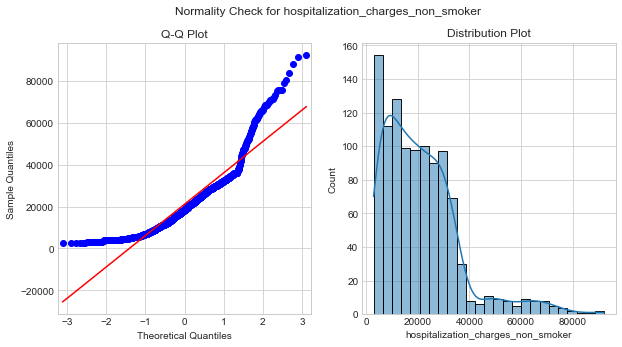

-------------------------------------------------------------------------------------
Shapiro-Wilk p-val: 0.0 | alpha: 0.05
We have sufficient evidence to say that hospitalization_charges_non_smoker doesn't come 
from a normal distribution.
-------------------------------------------------------------------------------------
Checking for Normality after Log-transformation:



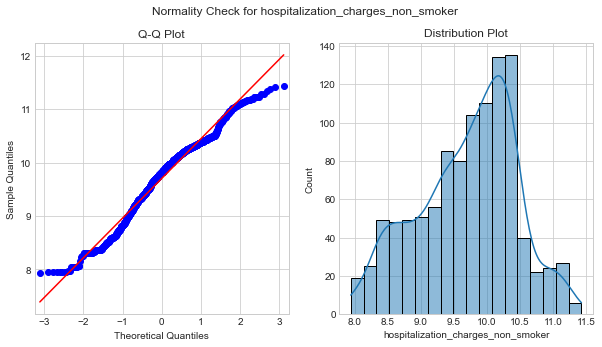

-------------------------------------------------------------------------------------
Shapiro-Wilk p-val: 0.0 | alpha: 0.05
We have sufficient evidence to say that hospitalization_charges_non_smoker doesn't come 
from a normal distribution.
-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
Levene's Test For Variance
Variables: ['hospitalization_charges_smoker', 'hospitalization_charges_non_smoker']
Proportion Cut: 0.05 | pvalue: 0.0
-------------------------------------------------------------------------------------
We have sufficient evidence to say that the variables don't have equal variance.
-------------------------------------------------------------------------------------


In [9]:
# Relevant datasets
smoker = hypo_test_data[hypo_test_data["smoker"] == "yes"]["hospitalization_charges"]
smoker.name = smoker.name + "_smoker"

non_smoker = hypo_test_data[hypo_test_data["smoker"] == "no"]["hospitalization_charges"]
non_smoker.name = non_smoker.name + "_non_smoker"

# Assumptions testing
hypo_test.normality_check(smoker)
hypo_test.normality_check(non_smoker)
hypo_test.variance_check(smoker, non_smoker)

<div class="alert alert-block alert-danger"><b><i>Assumptions</i></b></div>
<b>None of the assumptions for normality or equal variance between the two datasets are true. Since the sample is large, we can conclude easily from CLT that the sample mean of sample distributions would be normally distributed. Therefore, we will use Welch's t-test to accomodate for unequal variance and different sample sizes.</b>

In [10]:
hypo_test.ind_ttest(smoker, non_smoker, equal_var=False, alternative='greater')

-----------------------------------------------------------------
t-test | ('hospitalization_charges_smoker', 'hospitalization_charges_non_smoker')
alpha: 0.05 | pval: 0.0
We have sufficient evidence to reject the null hypothesis.
-----------------------------------------------------------------


<div class="alert alert-block alert-warning"><b><i>Result</i></b></div>
<b>We have sufficient evidence that suggests that the hospitalisation charges for a smoker are greater than the hospitalisation charges of a non-smoker</b>

---
### Viral Load of Females is Different than that of Males
**Hypothesis:**<br><br>
$ H_{0}: x_{females} = x_{males} $ <br>
$ H_{1}: x_{females} \neq x_{males} $


$\alpha = 0.05$

where, $x$ is viral load for any person.

-------------------------------------------------------------------------------------
viral_load_female



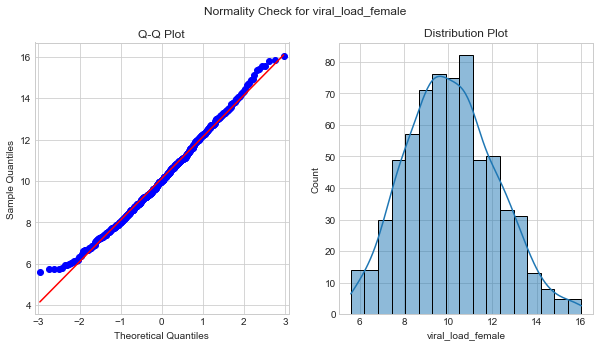

-------------------------------------------------------------------------------------
Shapiro-Wilk p-val: 0.0 | alpha: 0.05
We have sufficient evidence to say that viral_load_female doesn't come 
from a normal distribution.
-------------------------------------------------------------------------------------
Checking for Normality after Log-transformation:



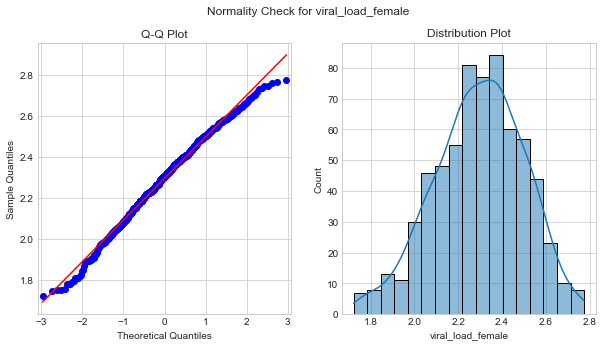

-------------------------------------------------------------------------------------
Shapiro-Wilk p-val: 0.0 | alpha: 0.05
We have sufficient evidence to say that viral_load_female doesn't come 
from a normal distribution.
-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
viral_load_male



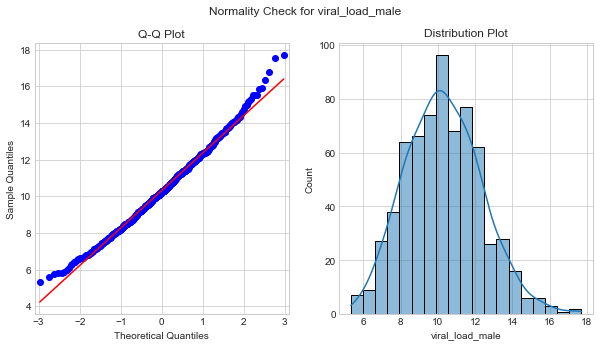

-------------------------------------------------------------------------------------
Shapiro-Wilk p-val: 0.0 | alpha: 0.05
We have sufficient evidence to say that viral_load_male doesn't come 
from a normal distribution.
-------------------------------------------------------------------------------------
Checking for Normality after Log-transformation:



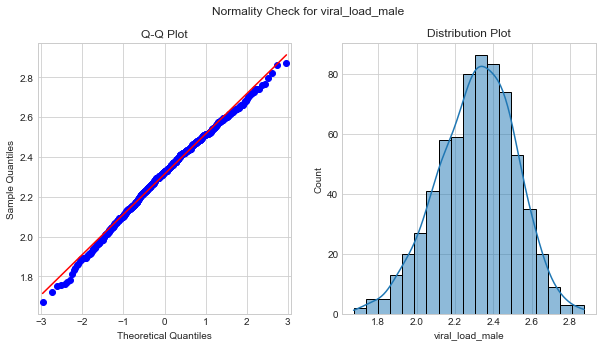

-------------------------------------------------------------------------------------
Shapiro-Wilk p-val: 0.02 | alpha: 0.05
We have sufficient evidence to say that viral_load_male doesn't come 
from a normal distribution.
-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
Levene's Test For Variance
Variables: ['viral_load_female', 'viral_load_male']
Proportion Cut: 0.05 | pvalue: 0.95
-------------------------------------------------------------------------------------
We do not have sufficient evidence to say that the variables don't have equal variance.
-------------------------------------------------------------------------------------


In [11]:
# Relevant datasets
viral_load_female = hypo_test_data[hypo_test_data["sex"] == "female"]["viral_load"]
viral_load_female.name = viral_load_female.name + "_female"

viral_load_male = hypo_test_data[hypo_test_data["sex"] == "male"]["viral_load"]
viral_load_male.name = viral_load_male.name + "_male"

# Assumptions testing
hypo_test.normality_check(viral_load_female)
hypo_test.normality_check(viral_load_male)
hypo_test.variance_check(viral_load_female, viral_load_male)

<div class="alert alert-block alert-danger"><b><i>Assumptions</i></b></div>
<b>Assumptions for normality for the two datasets is not true. Since the sample is large, we can conclude easily from CLT that the sample mean of sample distributions would be normally distributed. The assumption of equal variance however is met. Therefore, we will use Welch's t-test to accomodate different sample sizes.</b>

In [12]:
hypo_test.ind_ttest(viral_load_female, viral_load_male, equal_var=False)

-----------------------------------------------------------------
t-test | ('viral_load_female', 'viral_load_male')
alpha: 0.05 | pval: 0.09
We do not have sufficient evidence to reject the null hypothesis.
-----------------------------------------------------------------


<div class="alert alert-block alert-warning"><b><i>Result</i></b></div>
<b>We don't have sufficient evidence to conclude that the viral load between males and females is different statistically.</b>

---
### Is the Proportion of Smoking Significantly Different Across Regions?
**Hypothesis:**<br><br>
$ H_{0}: $ Proportion of smoking is not significantly different  <br>
$ H_{1}: $ Proportion of smoking is significantly different 


$\alpha = 0.05$

In [13]:
hypo_test.chi2(eda.contigency_table(index=["region"], columns = ["smoker"]))

-----------------------------------------------------------------
Chi-squared test
alpha: 0.05 | pval: 0.062
We do not have sufficient evidence to reject the null hypothesis.
-----------------------------------------------------------------


<div class="alert alert-block alert-warning"><b><i>Result</i></b></div>
<b>We don't have sufficent evidence to reject the null hypothesis, i.e., the proportion of people that smoke doesn't vary significantly across regions.</b>

---
### Viral Load among Women Varies w.r.t. Severity Level
**Hypothesis:**<br><br>
$ H_{0}: $ Mean viral load of women with severity level 0, 1, 2 is same.  <br>
$ H_{1}: $ Mean viral load of women with severity level 0, 1, 2 is not the same.


$\alpha = 0.05$

In [14]:
# Relevant datasets
viral_load_female = hypo_test_data[hypo_test_data["sex"] == "female"][["viral_load", "severity_level"]]

# Severity Levels
sev_lev_0 = viral_load_female.pivot(columns="severity_level").values.T[0]
sev_lev_0 = sev_lev_0[~np.isnan(sev_lev_0)]

sev_lev_1 = viral_load_female.pivot(columns="severity_level").values.T[1]
sev_lev_1 = sev_lev_1[~np.isnan(sev_lev_1)]

sev_lev_2 = viral_load_female.pivot(columns="severity_level").values.T[2]
sev_lev_2 = sev_lev_2[~np.isnan(sev_lev_2)]

hypo_test.one_way_anova(sev_lev_0, sev_lev_1, sev_lev_2)

-----------------------------------------------------------------
one-way ANOVA
alpha: 0.05 | pval: 0.72
We do not have sufficient evidence to reject the null hypothesis.
-----------------------------------------------------------------


<div class="alert alert-block alert-warning"><b><i>Result</i></b></div>
<b>We don't have sufficent evidence to reject the null hypothesis, i.e., mean viral load of women with severity level 0, 1 , 2 is the same.</b>

---
## Recommendations
<ul>
    <li>Smokers are charged more. They are clearly being penalised for bad health practices. The practice should be continued. At the same time, non-smokers should be given an incentive for treatment. This would increase the number of non-smoking patients coming to the hospital, thereby increasing revenue.
    <li>Since males smoke more than females, they should be charged more and treatment incentives for women should be put in place for a discount. This not only brings in more women but also addresses a social norm.
    <li>Since most people face Level 1 severity, the hospital can charge slightly higher for level 1 treatments. 
    <li>Level 4 severity patients both men and women, irrespective of whether they smoke or don't smoke see a high variance generally on the higher side for charges. This needs to be addressed and standardised by studying additional reasons for level 4 patients. The variance can then accordingly be replaced with a minimum base price, that adds to the bottom line.
    <li>Level 5 severity sees relatively younger patients with high variance existing in age. Patients with level 5 severity can be given an incentive for getting trated at Apollo, increasing the footfall and catering to the younger segment, who can be assumed to be having relatively lower income.
</ul>